# Notebook to process DNA methylation beta-values (minfi output) from illumina 450K array

### Load relevant libraries

In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import sklearn.preprocessing as pre
import warnings
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

## Read beta-values and metadata

In [143]:
beta_vals=pd.read_csv("merged_beta.csv")
int_metadata=pd.read_csv("internal_metadata.csv")
public_metadata=pd.read_csv("public_metadata.csv")

In [144]:
beta_vals.index=beta_vals["probeID"]
beta_vals=beta_vals.drop(columns="probeID")
### Remove probes on sex chromosome
beta_vals=beta_vals[beta_vals.index.str.contains('X')==False]
### Remove probes with missing values as only a small subset of probes have missing values
beta_vals=beta_vals.dropna()

## Perform sample-wise PCA to learn data biases

In [146]:
beta_vals_t=beta_vals.T
pca = PCA()
pca.fit(beta_vals_t)
pca_data = pca.transform(beta_vals_t)

### PCA output to dataframe and metadata merging

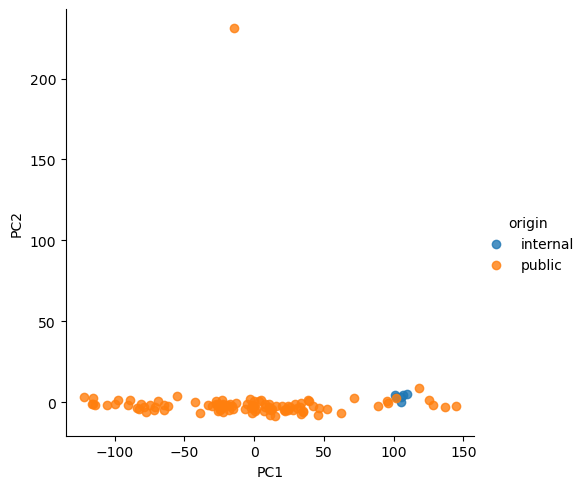

public_GSM5961849_202172220050_R07C01


In [150]:
pca_df = pd.DataFrame(data=pca_data, columns=[f'PC{i}' for i in range(1, pca_data.shape[1] + 1)])
sample_ids = beta_vals.columns
pca_df.index=sample_ids
pca_df['origin']=pca_df.index.str.split('_').str[0]
sns.lmplot(pca_df,x='PC1',y='PC2',hue='origin',fit_reg=False)
plt.show()
### Name of the outlier sample
print(pca_df[pca_df['PC2']>50].index[0])

### the plot above suggests that one sample is an outlier. We can ignore it for the visualization purposes. 
### PCA of the all other samples suggests 
### that internal samples align with only a few public data-samples which suggests some bias in public/internal datasests.

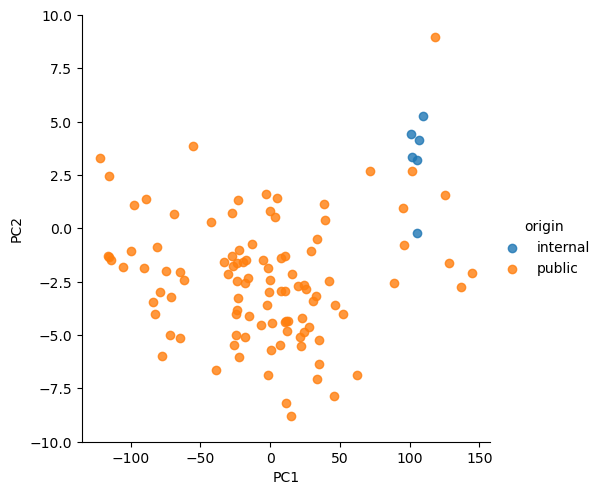

In [151]:
sns.lmplot(pca_df,x='PC1',y='PC2',hue='origin',fit_reg=False)
plt.ylim(-10,10)
plt.show()

### To understand the biases in datasets, I merged the metadata with the PCA dataframe and visualized further

In [152]:
#int_metadata.columns
int_metadata['study']='internal'
public_metadata['study']=public_metadata['GSE_ID']
public_metadata1=public_metadata[['title','sex','Age','study']].rename(columns={'title':'sample_id','Age':'age'})
metadata=pd.concat([public_metadata1,int_metadata[['sample_id', 'sex', 'age','study']]],axis=0)
metadata['sex']=metadata['sex'].str.replace('female','F')
metadata['sex']=metadata['sex'].str.replace('male','M')
pca_df.index=pca_df.index.str.split('_').str[-2]+'_'+pca_df.index.str.split('_').str[-1]
pca_df3=pd.merge(pca_df,metadata,left_index=True,right_on='sample_id')


### visualization to see if sex of the samples affect sample grouping in PCA. 
### The plot below suggests that it is not the bigeest confouder

(-10.0, 10.0)

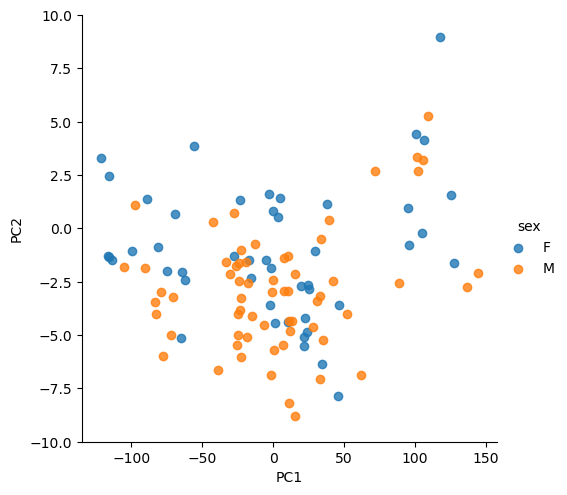

In [153]:
sns.lmplot(pca_df3,x='PC1',y='PC2',hue='sex',fit_reg=False)
plt.ylim(-10,10)

### the PCA variance is largely driven by the study. 
### Study in the public datasets are the GSE_ID. GSE_ID and contact_city, tissue and submission date.
### Thus, only the GSE_ID is considered as the bacth-effect/bias causing factor.

(-10.0, 10.0)

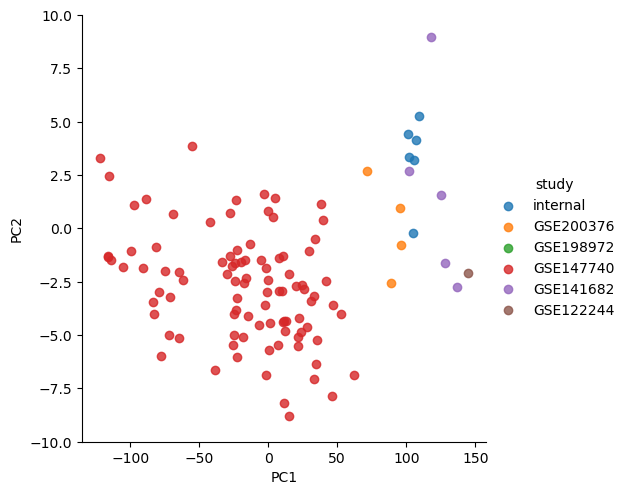

In [154]:
pca_df3=pca_df3.sort_values(by='study',ascending=False)
sns.lmplot(pca_df3,x='PC1',y='PC2',hue='study',fit_reg=False)
plt.ylim(-10,10)

### I like to use simple linear model to correct for such effects and also because these methods provide more flexibility.
### I applied a multi-variate linear regression of the beta-values with the study names and with the sex
### The adjusted beta-values will be the residuals from this multi-variate correction
### I did not include age as a factor in this adjustment because it is our variable of interest.


### Preparing X and y metrices for linear regression fit

In [155]:
#x=metadata[['sex','study']]
metadata.index=metadata['sample_id']

x_study=pd.get_dummies(metadata['study'], dtype=int)
x_sex=pd.get_dummies(metadata['sex'], dtype=int).drop('M',axis=1)
x=pd.merge(x_study,x_sex,left_index=True,right_index=True)
X = sm.add_constant(x)
y=beta_vals_t.copy()
y.index=y.index.str.split('_').str[-2]+'_'+y.index.str.split('_').str[-1]
y=y.loc[x.index,:]


### running the linear regression for each probe, one at a time
### We have about 800K probes and it takes ~20 mins on a 8 core laptop

In [ ]:
coef_dict=dict()
pval_dict=dict()
pred_dict=dict()
#c=0
for i in y:
    y1=y[i]
    model = sm.OLS(y1, X).fit()
    coef_dict[i]=model.params
    pval_dict[i]=model.pvalues
    pred_dict[i]=model.predict()
    #c=c+1
    #print(c)

coef_df=pd.DataFrame.from_dict(coef_dict)
pval_df=pd.DataFrame.from_dict(pval_dict)
pred_df=pd.DataFrame.from_dict(pred_dict)
pred_df.index=X.index
residuals=y-pred_df


### Check if linear model corrects adjusts the bias 

In [156]:
#metadata=metadata[metadata['study']!='GSE198972']
metadata_f=metadata.drop('sample_id',axis=1)
metadata_f['AgeDecade']=(metadata_f['age']//10)*10
#metadata.head()

### PCA from residuals to see if studies are still separated even after the adjustments

### PCA suggests that the multi-variate linear regression corrected the bias to a large extent

### the internal study samples and the public datasets now are mixed and appear as one big cluster

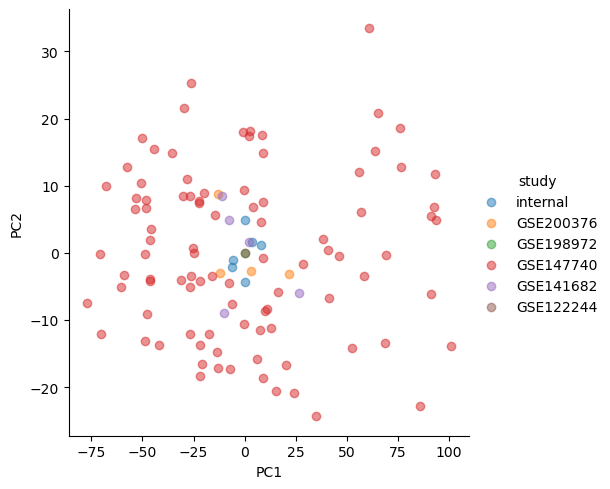

In [157]:
residuals=residuals.dropna()
pca = PCA()
pca.fit(residuals)
pca_resi = pca.transform(residuals)
pca_resi_df = pd.DataFrame(data=pca_resi, columns=[f'PC{i}' for i in range(1, pca_resi.shape[1] + 1)])
sample_ids = residuals.index
pca_resi_df.index=sample_ids
pca_resi_df2=pd.merge(pca_resi_df,metadata_f,left_index=True,right_index=True)
pca_resi_df2=pca_resi_df2.sort_values(by="study",ascending=False)
sns.lmplot(pca_resi_df2,x='PC1',y='PC2',hue='study',fit_reg=False,scatter_kws={'alpha': 0.5})


In [223]:
round(residuals,3).to_csv("Residual_beta_values_unscaled.csv")

### the samples are also mixed when analyzed by sex

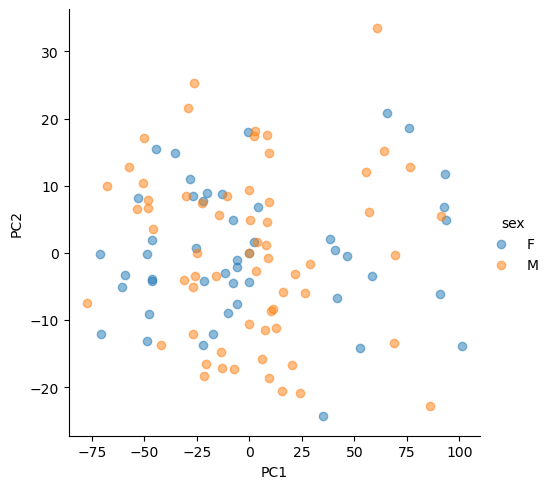

In [158]:
sns.lmplot(pca_resi_df2,x='PC1',y='PC2',hue='sex',fit_reg=False,scatter_kws={'alpha': 0.5})

### however, age still does not appear as the primary factor driving PCA 

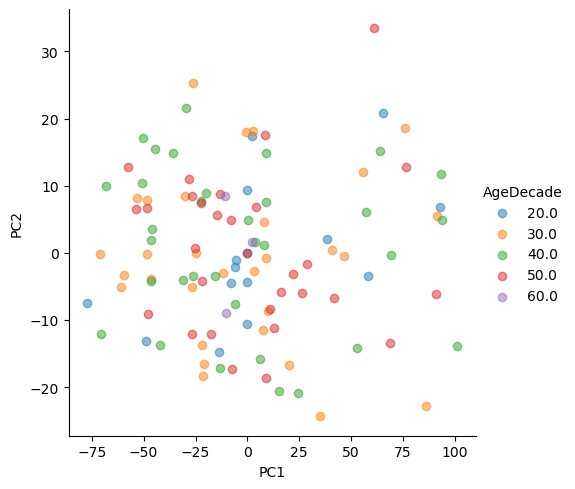

In [130]:
sns.lmplot(pca_resi_df2,x='PC1',y='PC2',hue='AgeDecade',fit_reg=False,scatter_kws={'alpha': 0.5})

## Regression of the age to identify probes related to age progression and then performing PCA on the selected probes

In [159]:
x_age=metadata['age']
X = sm.add_constant(x_age)
yr=residuals.copy()
yr=yr.loc[X.index,:]

In [160]:
age_coef_dict=dict()
age_pval_dict=dict()
#c=0
for i in yr:
    y1=yr[i]
    model = sm.OLS(y1, X).fit()
    age_coef_dict[i]=model.params
    age_pval_dict[i]=model.pvalues


In [174]:
age_coef_df=pd.DataFrame.from_dict(age_coef_dict).T
age_pval_df=pd.DataFrame.from_dict(age_pval_dict).T

In [184]:
age_coef_df1=age_coef_df.drop(columns='const')
age_pval_df1=age_pval_df.drop(columns='const')
age_coef_df_sig=age_coef_df1[age_pval_df1<0.05].dropna()

In [186]:
#subset corrected beta values only for the probes with significant association with age
age_related_probes=residuals[age_coef_df_sig.index]

Index(['cg00000029', 'cg00000103', 'cg00000109', 'cg00000155', 'cg00000158',
       'cg00000165', 'cg00000221', 'cg00000236', 'cg00000289', 'cg00000292',
       ...
       'ch.X.93511680F', 'ch.X.938089F', 'ch.X.94051109R', 'ch.X.94260649R',
       'ch.X.967194F', 'ch.X.97129969R', 'ch.X.97133160R', 'ch.X.97651759F',
       'ch.X.97737721F', 'ch.X.98007042R'],
      dtype='object', name='probeID', length=864573)

### PCA to see if the selected probes are able to segregate young peoplefrom old


In [193]:
pca = PCA()
pca.fit(age_related_probes)
pca_sel = pca.transform(age_related_probes)
pca_sel_df = pd.DataFrame(data=pca_sel, columns=[f'PC{i}' for i in range(1, pca_sel.shape[1] + 1)])
sample_ids = age_related_probes.index
pca_sel_df.index=sample_ids
pca_sel_df2=pd.merge(pca_sel_df,metadata_f,left_index=True,right_index=True)
pca_sel_df2=pca_sel_df2.sort_values(by="study",ascending=False)


### PC1 and PC2 somewhat segregate the young(20s from 50s) but not great

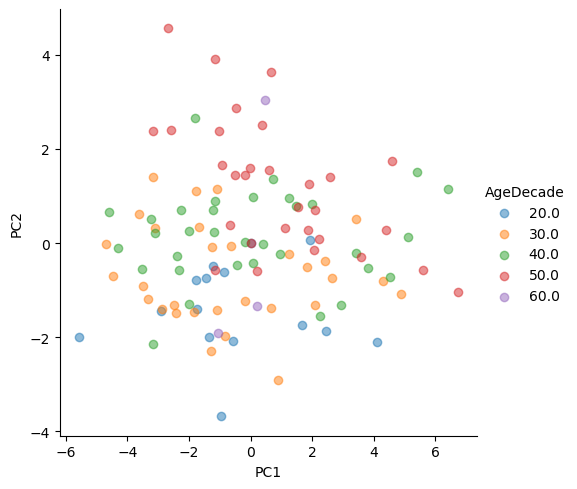

In [194]:
sns.lmplot(pca_sel_df2,x='PC1',y='PC2',hue='AgeDecade',fit_reg=False,scatter_kws={'alpha': 0.5})

In [196]:
### PC2 and PC3 are able to segregate the youngs(20s from 50s) from olds much better 
### and confirm that the selected probes has strong association with age

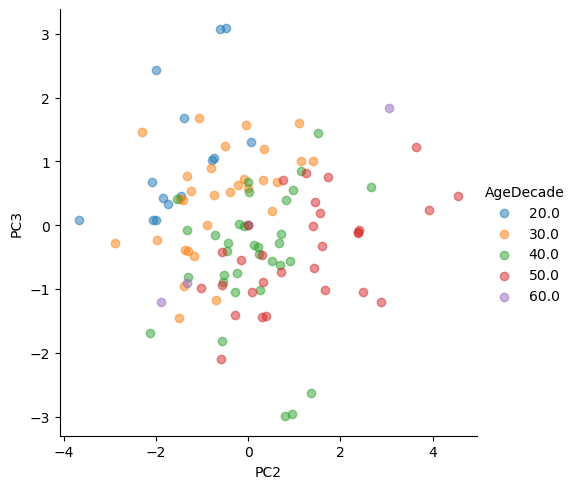

In [195]:
sns.lmplot(pca_sel_df2,x='PC2',y='PC3',hue='AgeDecade',fit_reg=False,scatter_kws={'alpha': 0.5})

In [198]:
age_related_probes.to_csv("unadjusted_beta_values_age_related_probes.csv")

In [200]:
residuals.max().max()

0.9566700236894363

### Since the residuals are regression fit prediction based, they can be more than 1 or sometimes negative
### min is -0.95
### max is 0.95
### Needs min-max scaling for each probeto conform with beta_value rules

In [224]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the scaler
scaler = MinMaxScaler()
# Fit and transform the data
normalized_residuals = scaler.fit_transform(residuals)
# Convert the array back to a dataframe
normalized_residuals = pd.DataFrame(normalized_residuals, columns=residuals.columns,index=residuals.index)
normalized_residuals=normalized_residuals
normalized_residuals=round(normalized_residuals,3)
normalized_residuals.to_csv("Normalized_and_corrected_beta_values.csv")

In [ ]:
## for any differential analysis non-normalized(not scaled between 1 and 0) but corrected beta values should work better 